<a href="https://colab.research.google.com/github/zzwony/Start_0920/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%ED%95%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터셋 내려받고 압축 풀기
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz 

In [3]:
# 입력 파일 경로와 분할 마스크 파일 경로를 각각 리스트로 구성하기
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")]) 

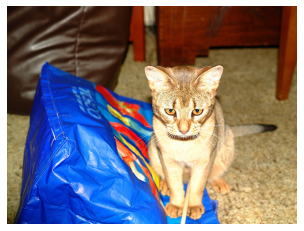

In [11]:
# 샘플 이미지 보기
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[7]))

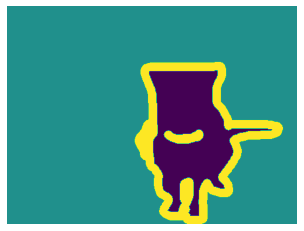

In [12]:
from locale import normalize
def display_target(target_array):
  normalize_array = (target_array.astype('uint8') - 1) * 127
  plt.axis('off')
  plt.imshow(normalize_array[:, :, 0])

img = img_to_array(load_img(target_paths[7], color_mode='grayscale'))
display_target(img)

In [13]:
# 입력과 타깃을 2개의 넘파이 배열로 로드하고
# 이 배열을 훈련과 검증 세트로 나눈다.
import numpy as np
import random

img_size = (200, 200)  ## 입격과 티깃을 모두 200x200 크기로 변경한다.
num_imgs = len(input_img_paths)  ## 데이터에 있는 전체 샘플 개수

random.Random(1337).shuffle(input_img_paths)  ## 파일 경로를 뒤섞는다.
random.Random(1337).shuffle(target_paths)     ## 입력 경로와 타깃 경로가 동일한 순서를 유지하도록
                                              ## 두 명령에 같은 시드(seed)(1337)를 사용한다.


def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1  ## 레이블이 0, 1, 2가 되도록 1을 뺀다.
    return img



## 전체 이미지를 input_imgs에 float32 배열로 로드하고 타깃 마스크는 targets에 로드한다.(같은 순서로)
## 입력은 3개의 채널(RGB 값)을 가지고 타깃은 (정수 레이블을 담은) 하나의 채널을 가진다.
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])



## 데이터를 훈련 세트와 검증 세트로 나눈다.
num_val_samples = 1000  ## 검증에 1000개의 샘플을 사용한다.
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:] 

In [15]:
# 모델 정의하기
from tensorflow import keras
from tensorflow.keras import layers



def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)  ## 입력 이미지를 [0-1]범위로 만드는 것을 잊지 말기
    
    ## 패딩이 특성 맵 크기에 영향을 미치지 않도록 모두 padding='same'으로 지정한다.
    ## Maxpooling 대신 strides=2을 사용했다.
    ## Maxpooling을 사용하면 풀링 윈도우 안의 위치 정보가 완전히 삭제 되어서
    ## 윈도우마다 하나의 스칼라 값을 반환하며 이 값이 윈도우 내의 네 위치 중 어디에서 왔는지
    ## 전혀 정보가 없기 때문에 대신 사용하였다.
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    ## 밑에 내용은 아까는 큰 대에서 작아졌는데 역으로 가면 다시 사진이 커진다. 
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    ## 각 출력 픽셀을 3개의 범주 중 하나로 분류하기 위해
    ## 3개의 유닛과 소프트맥스 활성화 함수를 가진 밀집 층으로 모델을 종료한다.
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model



model = get_model(img_size=img_size, num_classes=3)
model.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 256)       2951

In [16]:
# 모델을 컴파일 하고 훈련하기
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets)) 

Epoch 1/50
100/100 [==============================] - 89s 722ms/step - loss: 1.0766 - val_loss: 0.9858
Epoch 2/50
100/100 [==============================] - 62s 625ms/step - loss: 0.9203 - val_loss: 0.8135
Epoch 3/50
100/100 [==============================] - 63s 626ms/step - loss: 0.8320 - val_loss: 0.7640
Epoch 4/50
100/100 [==============================] - 63s 626ms/step - loss: 0.7840 - val_loss: 0.7070
Epoch 5/50
100/100 [==============================] - 63s 627ms/step - loss: 0.7384 - val_loss: 0.6675
Epoch 6/50
100/100 [==============================] - 62s 625ms/step - loss: 0.6879 - val_loss: 0.8899
Epoch 7/50
100/100 [==============================] - 63s 627ms/step - loss: 0.6541 - val_loss: 0.6304
Epoch 8/50
100/100 [==============================] - 63s 626ms/step - loss: 0.6152 - val_loss: 0.6272
Epoch 9/50
100/100 [==============================] - 63s 626ms/step - loss: 0.5874 - val_loss: 0.5544
Epoch 10/50
100/100 [==============================] - 62s 625ms/step - l